# U-Net implementation + Classification

In [1]:
import sys 
sys.path.append("../")

import torch 
import torch.nn

from Conv1d_NN import Conv1d_NN

from models import * 
from train import * 
from dataset import * 
from pixelshuffle import * 

### Data

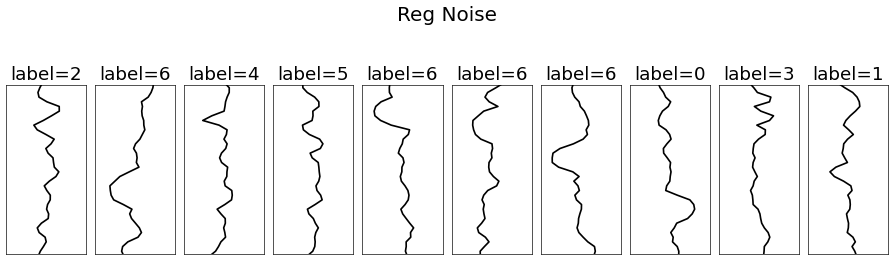

torch.Size([4000, 1, 40]) (4000,)


In [2]:
# Reg settings Data
reg_dataset = MNIST1D_Dataset()
reg_data = reg_dataset.make_dataset()
Plot = MNIST1D_Plot()
Plot.plot_signals(reg_data['x'][:10], reg_data['t'],labels = reg_data['y'][:10], zoom = 5, title='Reg Noise') 

print(reg_data['x'].shape, reg_data['y'].shape)

### U-net Model

In [5]:
U_net = nn.Sequential(
   # Initial Increase in channels 
   Conv1d_NN(in_channels= 1, out_channels=16, K=5, stride=5), 
   nn.ReLU(), 
   
   # Unshuffling
   PixelUnshuffle1D(2), 
   Conv1d_NN(in_channels=32, out_channels=32, K=5, stride=5), 
   nn.ReLU(), 
   PixelUnshuffle1D(2), 
   Conv1d_NN(in_channels=64, out_channels=64, K=5, stride=5), 
   nn.ReLU(), 
   PixelUnshuffle1D(2), 
   Conv1d_NN(in_channels=128, out_channels=128, K=5, stride=5), 
   nn.ReLU(), 
   
   # Shuffling 
   PixelShuffle1D(2), 
   Conv1d_NN(in_channels=64, out_channels=64, K=5, stride=5), 
   nn.ReLU(), 
   PixelShuffle1D(2), 
   Conv1d_NN(in_channels=32, out_channels=32, K=5, stride=5), 
   nn.ReLU(), 
   PixelShuffle1D(2), 
   Conv1d_NN(in_channels=16, out_channels=16, K=5, stride=5), 
   nn.ReLU(), 
   nn.Conv1d(in_channels=16, out_channels= 1, kernel_size=1), 
   
   # Flatten
   nn.Flatten(),
   nn.Linear(40, 10), 
   nn.ReLU()
   
)

# Get summary 
from torchsummary import summary 
summary(U_net, (1, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 40]              96
              ReLU-2               [-1, 16, 40]               0
         Conv1d_NN-3               [-1, 16, 40]               0
              ReLU-4               [-1, 16, 40]               0
  PixelUnshuffle1D-5               [-1, 32, 20]               0
            Conv1d-6               [-1, 32, 20]           5,152
              ReLU-7               [-1, 32, 20]               0
         Conv1d_NN-8               [-1, 32, 20]               0
              ReLU-9               [-1, 32, 20]               0
 PixelUnshuffle1D-10               [-1, 64, 10]               0
           Conv1d-11               [-1, 64, 10]          20,544
             ReLU-12               [-1, 64, 10]               0
        Conv1d_NN-13               [-1, 64, 10]               0
             ReLU-14               [-1,

In [6]:
# U Net results
print("U Net implementation results")
results1 = train_model(reg_data, U_net, reg_dataset.model_args)

U Net implementation results
step 1000, dt 48.97s, train_loss 1.943e+00, test_loss 2.074e+00, train_acc 22.6, test_acc 22.7
step 2000, dt 41.72s, train_loss 1.888e+00, test_loss 2.017e+00, train_acc 24.5, test_acc 25.1
step 3000, dt 40.10s, train_loss 1.531e+00, test_loss 1.582e+00, train_acc 41.7, test_acc 40.5
step 4000, dt 39.42s, train_loss 1.419e+00, test_loss 1.505e+00, train_acc 46.0, test_acc 44.9
step 5000, dt 39.76s, train_loss 1.424e+00, test_loss 1.474e+00, train_acc 48.0, test_acc 45.0
step 6000, dt 39.55s, train_loss 1.774e+00, test_loss 1.437e+00, train_acc 52.0, test_acc 47.1


### Modified U-Net

In [7]:
class ModifiedUNet(nn.Module):
    def __init__(self):
        super(ModifiedUNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(Conv1d_NN(in_channels=1, out_channels=16, K=5, stride=5), nn.ReLU())
        self.down1 = PixelUnshuffle1D(2)
        self.enc2 = nn.Sequential(Conv1d_NN(in_channels=32, out_channels=64, K=5, stride=5), nn.ReLU())
        self.down2 = PixelUnshuffle1D(2)
        self.enc3 = nn.Sequential(Conv1d_NN(in_channels=128, out_channels=256, K=5, stride=5), nn.ReLU())
        self.down3 = PixelUnshuffle1D(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(Conv1d_NN(in_channels=512, out_channels=512, K=5, stride=5), nn.ReLU())
        
        # Decoder
        self.up1 = PixelShuffle1D(2)
        self.dec1 = nn.Sequential(Conv1d_NN(in_channels=256, out_channels=128, K=5, stride=5), nn.ReLU())
        self.up2 = PixelShuffle1D(2)
        self.dec2 = nn.Sequential(Conv1d_NN(in_channels=64, out_channels=32, K=5, stride=5), nn.ReLU())
        self.up3 = PixelShuffle1D(2)
        self.dec3 = nn.Sequential(Conv1d_NN(in_channels=16, out_channels=5, K=5, stride=5), nn.ReLU())

        
        # Final layer
        self.final = nn.Sequential(nn.Conv1d(in_channels=5, out_channels=1, kernel_size=1), nn.Flatten(), nn.Linear(40, 10), nn.ReLU())

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)        
        down1 = self.down1(enc1)
        enc2 = self.enc2(down1)
        down2 = self.down2(enc2)
        enc3 = self.enc3(down2)
        down3 = self.down3(enc3)
        
        # Bottleneck
        bottleneck = self.bottleneck(down3)
        
        # Decoder
        up1 = self.up1(bottleneck)
        dec1 = self.dec1(up1)
        up2 = self.up2(dec1)
        dec2 = self.dec2(up2)
        up3 = self.up3(dec2)
        dec3 = self.dec3(up3)
        # Final layer
        out = self.final(dec3)
        return out

In [8]:
modified_UNet = ModifiedUNet()

summary(modified_UNet, (1, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 40]              96
              ReLU-2               [-1, 16, 40]               0
         Conv1d_NN-3               [-1, 16, 40]               0
              ReLU-4               [-1, 16, 40]               0
  PixelUnshuffle1D-5               [-1, 32, 20]               0
            Conv1d-6               [-1, 64, 20]          10,304
              ReLU-7               [-1, 64, 20]               0
         Conv1d_NN-8               [-1, 64, 20]               0
              ReLU-9               [-1, 64, 20]               0
 PixelUnshuffle1D-10              [-1, 128, 10]               0
           Conv1d-11              [-1, 256, 10]         164,096
             ReLU-12              [-1, 256, 10]               0
        Conv1d_NN-13              [-1, 256, 10]               0
             ReLU-14              [-1, 

In [9]:
# U Net results
print("Modified U Net implementation results")
results2 = train_model(reg_data, modified_UNet, reg_dataset.model_args)

Modified U Net implementation results
step 1000, dt 92.74s, train_loss 1.258e+00, test_loss 1.256e+00, train_acc 53.0, test_acc 51.0
step 2000, dt 91.31s, train_loss 1.078e+00, test_loss 1.138e+00, train_acc 59.3, test_acc 55.1
step 3000, dt 75.35s, train_loss 1.018e+00, test_loss 1.199e+00, train_acc 63.1, test_acc 54.7
step 4000, dt 75.26s, train_loss 1.108e+00, test_loss 1.148e+00, train_acc 65.5, test_acc 56.1
step 5000, dt 75.05s, train_loss 9.226e-01, test_loss 1.271e+00, train_acc 67.6, test_acc 54.6
step 6000, dt 74.94s, train_loss 8.369e-01, test_loss 1.273e+00, train_acc 69.4, test_acc 57.0
